# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Data

In [2]:
data_dir = "/Users/rajesharasada/Documents/DataScience/Imbalanced_Data_Classification/data/raw/dataset_diabetes/"

In [3]:
# List the data files in the raw data observations
os.listdir(data_dir)

['IDs_mapping.csv', 'diabetic_data.csv']

In [4]:
# Define the path to the data file
data_file = os.path.join(data_dir, 'diabetic_data.csv')

# Understanding Data

## Observations

In [5]:
# Read the csv file
df = pd.read_csv(data_file)
# Visulaize few observations to understand the data
df.sample(5)
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# Determine Level of Dataset (Line or Encounter)¶

**Line Level**: If the total number of rows is greater than the number of unique encounters, it is at the line level.

**Encounter Level**: Every interaction between a patient and healthcare provider is an encounter. So if the total number of rows is equal to the number of unique encounters, it is at the encounter level.

**Longitudinal Level**: For the longitudinal or patient level, you will see multiple encounters grouped under a patient and you might not even see the encounter id field since this information is collapsed/aggregated under a unique patient id. In this case, the total number of rows should equal the total number of unique patients.

In [6]:
# Line test
try:
    assert len(df) > df['encounter_id'].nunique()
    print("The dataset is at LINE LEVEL")
except:
    print("This dataset is not at LINE LEVEL")

This dataset is not at LINE LEVEL


In [7]:
# Encounter Test
try:
    assert len(df) == df['encounter_id'].nunique()
    print(
        "The dataset could be at the ENCOUNTER LEVEL with {} observations and unique encounters"
        .format(len(df)))
except:
    print("The dataset is NOT at the ENCOUNTER LEVEL")

The dataset could be at the ENCOUNTER LEVEL with 101766 observations and unique encounters


# Data leakage from multiple encounters for each patient

Having multiple encounters for a patient can lead to data leakage of future patient encounters. To avoid this we need to determine if there is more than one encounter per patient and select either the first encounter or the last encounter for each patient in the dataset. This is to reduce the risk of data leakage and reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [8]:
def select_first_encounter(df):
    '''
    df: pandas dataframe, dataframe with all encounters
    return:
        - first_encounter_df: pandas dataframe, dataframe with only the first encounter for a given patient
    '''
    first_encounter = df.sort_values(["encounter_id", "patient_nbr"], ascending=[True, True]).groupby("patient_nbr").head(1).reset_index(drop=True)
    return first_encounter

In [9]:
first_encounter_df = select_first_encounter(df)
first_encounter_df.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
69654,402081650,141459467,Caucasian,Male,[80-90),?,1,1,7,2,...,No,Steady,No,No,No,No,No,No,Yes,<30
48082,179005146,24623622,Caucasian,Male,[70-80),?,3,6,1,5,...,No,Down,No,No,No,No,No,Ch,Yes,NO
438,3996996,22757895,AfricanAmerican,Male,[70-80),?,2,1,4,3,...,No,Steady,No,No,No,No,No,No,Yes,NO
31662,128578782,36742446,Caucasian,Female,[60-70),?,1,1,7,2,...,No,Steady,No,No,No,No,No,No,Yes,>30
38281,150791748,43751655,Caucasian,Male,[70-80),?,3,1,1,11,...,No,Down,No,No,No,No,No,Ch,Yes,NO


In [10]:
def select_last_encounter(df):
    '''
    df: pandas dataframe, dataframe with all encounters
    return:
        - last_encounter_df: pandas dataframe, dataframe with only the last encounter for a given patient
    '''
    last_encounter_df = df.sort_values(["encounter_id", "patient_nbr"], ascending=[True, True]).groupby("patient_nbr").tail(1).reset_index(drop=True)
    return last_encounter_df

In [11]:
last_encounter_df = select_last_encounter(df)
last_encounter_df.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
17116,83275584,1294677,Caucasian,Female,[40-50),?,1,1,7,3,...,No,No,No,No,No,No,No,No,No,NO
43438,174357360,25404678,AfricanAmerican,Male,[60-70),?,1,3,7,7,...,No,Steady,No,No,No,No,No,No,Yes,>30
19971,92103654,74064519,Caucasian,Female,[60-70),?,3,6,4,10,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
60905,287246682,98599788,Caucasian,Female,[50-60),?,1,1,7,3,...,No,No,No,No,No,No,No,No,No,NO
4420,33227400,1142559,Caucasian,Female,[50-60),?,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO


# Save the datasets

In [16]:
first_encounter_df.to_csv("../data/processed/first_encounter.csv",index=False )
last_encounter_df.to_csv("../data/processed/last_encounter.csv",index=False )

# Dead patients
Before any further data wrangling and feature engineering we will drop any observations that don't add any value to the data and data analysis. Patients who expired are unlikely to get readmitted. Information of patients who expired can be dropped. We can obtain their information from the supplementary information and the feature 'discharge_disposition_id'. 

In [10]:
df = df[~df['discharge_disposition_id'].isin([11, 19, 20, 21])]
# Reset the index
df.reset_index(inplace=True)
df.sample(5)

,index,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
5803,5906,33998724,11261331,Caucasian,Male,[40-50),?,3,5,1,...,No,No,No,No,No,No,No,No,No,NO
31544,32052,129963858,93334239,Caucasian,Female,[60-70),?,2,6,1,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
28304,28742,117628128,64603548,Caucasian,Female,[40-50),?,2,1,1,...,No,No,No,No,No,No,No,No,Yes,NO
7947,8089,42558360,5452929,AfricanAmerican,Female,[30-40),?,1,1,7,...,No,Up,No,No,No,No,No,Ch,Yes,NO
2158,2189,16333980,11945295,AfricanAmerican,Female,[50-60),?,3,1,1,...,No,No,No,No,No,No,No,No,No,NO


In [10]:
df["patient_nbr"].nunique()

71518

In [16]:
df["num_encounters"] = df.groupby("patient_nbr")["encounter_id"].transform("count")

In [21]:
df.sort_values(["num_encounters"], ascending=False)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,num_encounters
78355,239153370,88785891,Caucasian,Female,[20-30),?,1,1,7,7,...,Up,No,No,No,No,No,Ch,Yes,<30,40
76907,232655340,88785891,Caucasian,Female,[20-30),?,2,1,7,4,...,Down,No,No,No,No,No,Ch,Yes,>30,40
87854,281267754,88785891,Caucasian,Female,[20-30),?,1,1,7,7,...,Up,No,No,No,No,No,Ch,Yes,<30,40
91444,309563132,88785891,Caucasian,Female,[20-30),?,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,<30,40
88392,284109186,88785891,Caucasian,Female,[20-30),?,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,>30,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41403,128083350,23792328,AfricanAmerican,Female,[50-60),?,3,1,1,2,...,Steady,No,No,No,No,No,No,Yes,NO,1
41404,128092554,23277078,Caucasian,Female,[40-50),?,3,1,1,1,...,No,No,No,No,No,No,No,No,NO,1
41405,128108976,97821405,Caucasian,Female,[60-70),?,3,1,1,2,...,Steady,No,No,No,No,No,Ch,Yes,>30,1
41408,128115234,42905664,Caucasian,Male,[60-70),?,3,1,1,2,...,No,No,No,No,No,No,No,Yes,NO,1


In [27]:

def compute_plot_countplot(df, col, ylabel, figsize): 
    """
    Computes and plots a countplot
    Args:
        df - name of the dataframe
        col - column to count the values for
        ylabel- name of the column
    """
    # 1. compute counts for each unique value in the column
    #    and convert it into a dictionary
    value_counts = df[col].value_counts().to_dict()
    
    # 2. extract the unique values and its count as a list
    values = list(value_counts.keys())
    counts = list(value_counts.values())
    

    # 3. plot a horizontal bar graph
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(values, counts, color = '#EE6666')
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel("Count", fontsize=14)

    plt.show()   

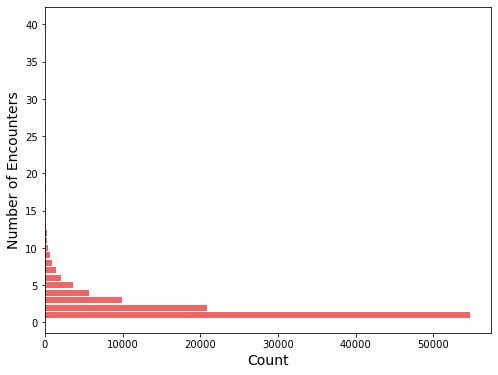

In [28]:
 compute_plot_countplot(df, "num_encounters", "Number of Encounters", (8,6))

In [22]:
df[df['patient_nbr'] == 88785891]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,num_encounters
38307,119039172,88785891,Caucasian,Female,[20-30),?,1,1,7,1,...,Up,No,No,No,No,No,Ch,Yes,>30,40
40252,125094312,88785891,Caucasian,Female,[20-30),?,1,1,7,1,...,Down,No,No,No,No,No,Ch,Yes,<30,40
40661,126171582,88785891,Caucasian,Female,[20-30),?,1,1,7,5,...,Up,No,No,No,No,No,Ch,Yes,>30,40
44515,137245596,88785891,Caucasian,Female,[20-30),?,3,1,7,2,...,Up,No,No,No,No,No,Ch,Yes,<30,40
45147,139425576,88785891,Caucasian,Female,[20-30),?,1,1,7,2,...,Up,No,No,No,No,No,Ch,Yes,<30,40
45986,141994242,88785891,Caucasian,Female,[20-30),?,2,1,7,4,...,Up,No,No,No,No,No,Ch,Yes,<30,40
50167,150986298,88785891,Caucasian,Female,[20-30),?,2,1,7,1,...,Up,No,No,No,No,No,Ch,Yes,<30,40
50393,151413846,88785891,Caucasian,Female,[20-30),?,1,1,7,4,...,Up,No,No,No,No,No,Ch,Yes,<30,40
50773,152188656,88785891,Caucasian,Female,[20-30),?,2,7,7,1,...,Up,No,No,No,No,No,Ch,Yes,<30,40
51519,153558456,88785891,Caucasian,Female,[20-30),?,2,1,7,1,...,Up,No,No,No,No,No,Ch,Yes,<30,40


In [27]:
df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [28]:
numeric_features = df.select_dtypes(exclude='object')
categorical_features = df.select_dtypes(include='object')

for f in categorical_features:
    print(categorical_features[f].unique())
    print()

NA_VALUES = ['?', 'None','Unknown/Invalid']

df_ = pd.read_csv(data_file,na_values=NA_VALUES)
df_.sample(5)

df_.isna().sum()

In [34]:
numeric_features_ = df_.select_dtypes(exclude='object')
categorical_features_ = df_.select_dtypes(include='object')

In [ ]:
or f in categorical_features:
    print(categorical_features[f].unique())
    print()

In [26]:
for f in numeric_features:
    print(numeric_features[f].unique())
    print()

[  2278392    149190     64410 ... 443854148 443857166 443867222]

[  8222157  55629189  86047875 ... 140199494 120975314 175429310]

[6 1 2 3 4 5 8 7]

[25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]

[ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]

[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]

[ 41  59  11  44  51  31  70  73  68  33  47  62  60  55  49  75  45  29
  35  42  66  36  19  64  25  53  52  87  27  37  46  28  48  72  10   2
  65  67  40  54  58  57  43  32  83  34  39  69  38  56  22  96  78  61
  88  50   1  18  82   9  63  24  71  77  81  76  90  93   3 103  13  80
  85  16  15  12  30  23  17  21  79  26   5  95  97  84  14  74 105  86
  98  20   6  94   8 102 100   7  89  91  92   4 101  99 114 113 111 129
 107 108 106 104 109 120 132 121 126 118]

[0 5 1 6 2 3 4]

[ 1 18 13 16  8 21 12 28 17 11 15 31  2 23 19  7 20 14 10 22  9 27 25  4
 32  6 30 26 24 33  5 39  3 29 61 40 46 41 36 34 35 50 43 42 37 51 38 45
 54 52 49 62 55 47 44 

In [14]:
def get_unique_values(df):
    """
    Identifies the unique values in each feature of a dataframe
    Arg: df - dataframe
    Return: df with feature name, number of unique values and unique values
    """
    feature_names = []
    unique_values = []
    num_unique_values = []

    for f in df:
        feature_names.append(f)
        unique_values.append(df[f].unique())
        num_unique_values.append(df[f].nunique())

    unique_values_df = pd.DataFrame({
        "feature": feature_names,
        "unique_values": unique_values,
        "num_unique": num_unique_values})
    return unique_values_df

In [15]:
cat_features_unique = get_unique_values(categorical_features)
cat_features_unique

,feature,unique_values,num_unique
0,race,"[Caucasian, AfricanAmerican, ?, Other, Asian, ...",6
1,gender,"[Female, Male, Unknown/Invalid]",3
2,age,"[[0-10), [10-20), [20-30), [30-40), [40-50), [...",10
3,weight,"[?, [75-100), [50-75), [0-25), [100-125), [25-...",10
4,payer_code,"[?, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, CH...",18
5,medical_specialty,"[Pediatrics-Endocrinology, ?, InternalMedicine...",73
6,diag_1,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434,...",717
7,diag_2,"[?, 250.01, 250, 250.43, 157, 411, 492, 427, 1...",749
8,diag_3,"[?, 255, V27, 403, 250, V45, 38, 486, 996, 197...",790
9,max_glu_serum,"[None, >300, Norm, >200]",4


In [16]:
num_features_unique = get_unique_values(numeric_features)
num_features_unique

,feature,unique_values,num_unique
0,encounter_id,"[2278392, 149190, 64410, 500364, 16680, 35754,...",101766
1,patient_nbr,"[8222157, 55629189, 86047875, 82442376, 425192...",71518
2,admission_type_id,"[6, 1, 2, 3, 4, 5, 8, 7]",8
3,discharge_disposition_id,"[25, 1, 3, 6, 2, 5, 11, 7, 10, 4, 14, 18, 8, 1...",26
4,admission_source_id,"[1, 7, 2, 4, 5, 6, 20, 3, 17, 8, 9, 14, 10, 22...",17
5,time_in_hospital,"[1, 3, 2, 4, 5, 13, 12, 9, 7, 10, 6, 11, 8, 14]",14
6,num_lab_procedures,"[41, 59, 11, 44, 51, 31, 70, 73, 68, 33, 47, 6...",118
7,num_procedures,"[0, 5, 1, 6, 2, 3, 4]",7
8,num_medications,"[1, 18, 13, 16, 8, 21, 12, 28, 17, 11, 15, 31,...",75
9,number_outpatient,"[0, 2, 1, 5, 7, 9, 3, 8, 4, 12, 11, 6, 20, 15,...",39


In [21]:
print(num_features_unique.loc[num_features_unique["feature"] == "number_emergency", "unique_values"])

10    [0, 1, 2, 4, 3, 9, 5, 7, 6, 8, 22, 25, 10, 13,...
Name: unique_values, dtype: object


In [11]:
feature_names = []
unique_values = []
num_unique_values = []
for f in numeric_features:
    feature_names.append(f)
    unique_values.append(numeric_features[f].unique())
    num_unique_values.append(numeric_features[f].nunique())

num_features_df = pd.DataFrame({
    "feature": feature_names,
    "unique_values": unique_values,
    "num_unique": num_unique_values 
})

num_features_df

,feature,unique_values,num_unique
0,encounter_id,"[2278392, 149190, 64410, 500364, 16680, 35754,...",101766
1,patient_nbr,"[8222157, 55629189, 86047875, 82442376, 425192...",71518
2,admission_type_id,"[6, 1, 2, 3, 4, 5, 8, 7]",8
3,discharge_disposition_id,"[25, 1, 3, 6, 2, 5, 11, 7, 10, 4, 14, 18, 8, 1...",26
4,admission_source_id,"[1, 7, 2, 4, 5, 6, 20, 3, 17, 8, 9, 14, 10, 22...",17
5,time_in_hospital,"[1, 3, 2, 4, 5, 13, 12, 9, 7, 10, 6, 11, 8, 14]",14
6,num_lab_procedures,"[41, 59, 11, 44, 51, 31, 70, 73, 68, 33, 47, 6...",118
7,num_procedures,"[0, 5, 1, 6, 2, 3, 4]",7
8,num_medications,"[1, 18, 13, 16, 8, 21, 12, 28, 17, 11, 15, 31,...",75
9,number_outpatient,"[0, 2, 1, 5, 7, 9, 3, 8, 4, 12, 11, 6, 20, 15,...",39
